In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from pyrl.agents import QLearning as ClassicQLearning
from pyrl.agents.survival import QLearning as SurvivalQLearning
from pyrl.agents.survival import KLearning
from pyrl.environments.survival import SurvivalEnv
from pyrl import Sim

## Test with rendering

In [8]:

map_size = (50, 5)
minor_r=5, 
major_r=50, 
step_r=-1
horizon = 5000
initial_Q_value = 0
initial_K_value = 200
survival_threshold = 250
exploration_threshold = 500
gamma = 0.95 #discount factor
alpha = 0.5 #learning rate
epsilon=0.5 #exploration rate
initial_budget = 500

#map_size = (50, 5)
#horizon = 10000
#initial_budget = 600
#survival_threshold = 200
#exploration_threshold = 400

#env = gym.make("pyrl.environments:Survival-v0", size=map_size, render_mode="human")
env = SurvivalEnv(size=map_size, minor_r=5, major_r=20, step_r=-1, render_mode="human")

def episode_callback(env, agent):
    #print("END EPISODE")
    pass

def simulation_callback(env, agent):
    #print("END SIM")
    env.close()

def step_callback(env, agent):
    #print(".", end='')
    env.agent = agent
    #env.agent = agent

    
agent_K = KLearning(
    env,
    #initial_budget=initial_budget,
    should_explore=None,
    discount=gamma,
    learning_rate=alpha,
    initial_Q_value=initial_Q_value,
    initial_K_value=initial_K_value,
    survival_threshold=survival_threshold,
    exploration_threshold=exploration_threshold,
)

agent_Q = ClassicQLearning(env.observation_space, 
                         env.action_space, 
                         budget=initial_budget, 
                         discount=gamma,
                         learning_rate=alpha,
                         exploration_rate=epsilon,
                         initial_Q_value=initial_Q_value)

env.agent = agent_Q

sim = Sim(agent, env, episode_horizon=horizon, 
          episode_finished_callback=episode_callback, 
          simulation_finished_callback=simulation_callback,
          round_finished_callback=step_callback
         )
sim.run()


AttributeError: 'SurvivalEnv' object has no attribute 'observation_shape'

In [73]:
map_size = (50, 5)
minor_r=5, 
major_r=50, 
step_r=-1
horizon = 5000
initial_Q_value = 0
initial_K_value = 200
survival_threshold = 400
exploration_threshold = 800
gamma = 0.95 #discount factor
alpha = 0.5 #learning rate
epsilon = 0.1 #exploration rate
repeat = 100
budgets = np.array([100, 200, 300, 400, 500, 600, 700, 800])

#env = gym.make("pyrl.environments:Survival-v0", size=map_size, render_mode="human")
env = gym.make("pyrl.environments:Survival-v0", size=map_size)

## Classic QLearning 0.1

In [65]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.1

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_1_time_mean = qclassic_time_mean
qclassic_1_exploration_rate = qclassic_exploration_rate
qclassic_1_alive_rate = qclassic_alive_rate
qclassic_1_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_1_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_1_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_1_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 141
Alive rate : 1%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 228
Alive rate : 1%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 869

## Classic QLearning 0.3

In [ ]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.3

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_3_time_mean = qclassic_time_mean
qclassic_3_exploration_rate = qclassic_exploration_rate
qclassic_3_alive_rate = qclassic_alive_rate
qclassic_3_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_3_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_3_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_3_exploration_map = qclassic_exploration_map

## Classic QLearning greedy

In [77]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.0

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_0_time_mean = qclassic_time_mean
qclassic_0_exploration_rate = qclassic_exploration_rate
qclassic_0_alive_rate = qclassic_alive_rate
qclassic_0_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_0_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_0_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_0_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 469
Alive rate : 6%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 113

In [86]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.0

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_K_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_h_time_mean = qclassic_time_mean
qclassic_h_exploration_rate = qclassic_exploration_rate
qclassic_h_alive_rate = qclassic_alive_rate
qclassic_h_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_h_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_h_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_h_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 200
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Time mean : 300

## Survival QLearning

In [69]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=250,
            exploration_threshold=500,
        )
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_250_time_mean = qsurvival_time_mean
qsurvival_250_exploration_rate = qsurvival_exploration_rate
qsurvival_250_alive_rate = qsurvival_alive_rate
qsurvival_250_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_250_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_250_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_250_exploration_map = qsurvival_exploration_map
        

b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* average survival time : 570
* alive rate : 7%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* avera

In [76]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=400,
            exploration_threshold=800,
        )
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_400_time_mean = qsurvival_time_mean
qsurvival_400_exploration_rate = qsurvival_exploration_rate
qsurvival_400_alive_rate = qsurvival_alive_rate
qsurvival_400_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_400_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_400_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_400_exploration_map = qsurvival_exploration_map

b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* average survival time : 515
* alive rate : 7%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* avera

In [93]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=600,
            exploration_threshold=1000,
        )
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_600_time_mean = qsurvival_time_mean
qsurvival_600_exploration_rate = qsurvival_exploration_rate
qsurvival_600_alive_rate = qsurvival_alive_rate
qsurvival_600_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_600_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_600_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_600_exploration_map = qsurvival_exploration_map

b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* average survival time : 513
* alive rate : 7%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
* avera

## Results

### Survival time

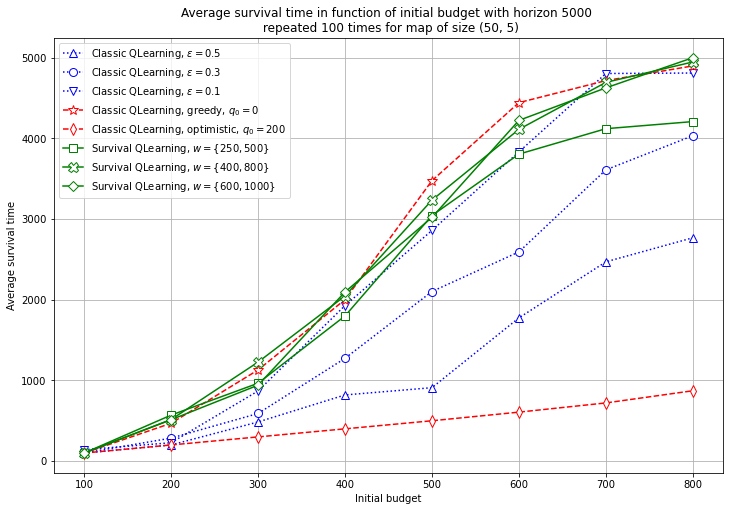

In [120]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, qclassic_5_time_mean, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_time_mean, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_time_mean, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_time_mean, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_time_mean, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_time_mean, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_time_mean, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_time_mean, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Average survival time")
plt.legend()
plt.grid()
plt.title(f"Average survival time in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")  #and survival threshold [{survival_threshold}-{exploration_threshold}] 
plt.show()

### Alive rate

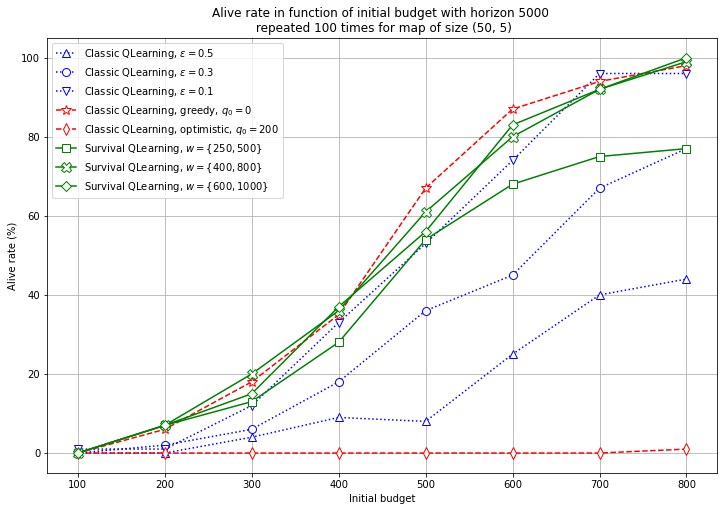

In [119]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, qclassic_5_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_alive_rate, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_alive_rate, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_alive_rate, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_alive_rate, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_alive_rate, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.grid()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Exploration rate

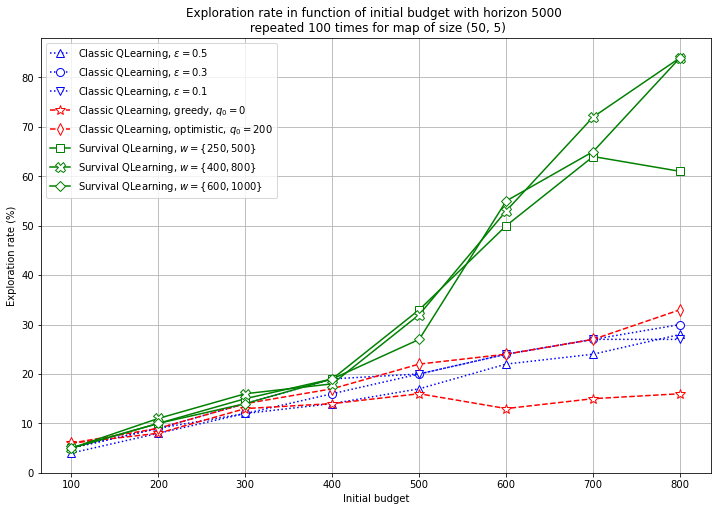

In [118]:
fig = plt.figure(figsize=(12, 8))
#plt.plot(budgets, cde_exploration_rate, label="CDELearning")
plt.plot(budgets, qclassic_5_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_exploration_rate, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_exploration_rate, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_exploration_rate, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_exploration_rate, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_exploration_rate, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Exploration rate (%)")
plt.legend()
plt.grid()
plt.title(f"Exploration rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Budget evolution

In [109]:
print("Available budgets :")
print(budgets)

#plt.rcParams["figure.figsize"] = (10,10)

with_bounds = False

show_only = [300, 400, 500]
colors = ['r', 'g', 'b']


Available budgets :
[100 200 300 400 500 600 700 800]


#### QLearning

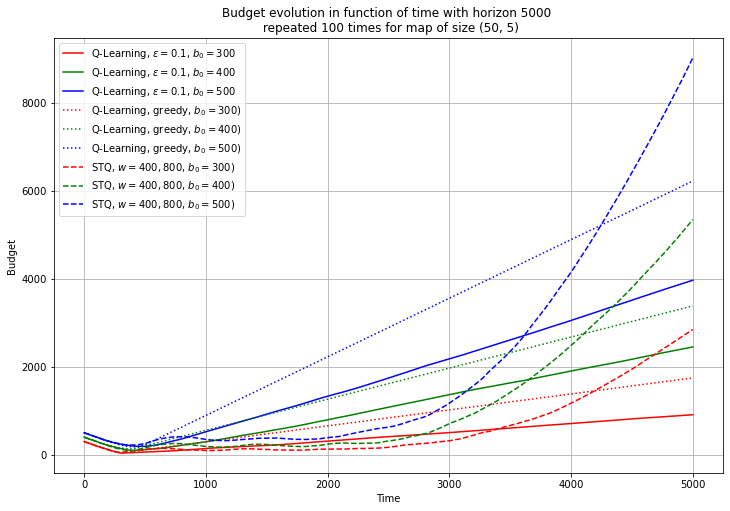

In [117]:
t = np.arange(horizon)

fig = plt.figure(figsize=(12, 8))

n=0
for i, evo in enumerate(qclassic_1_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, $\\varepsilon=0.1$, $b_0=${budgets[i]}", ls='-', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qclassic_1_budget_evolutions_min[i], qclassic_1__budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

n=0
for i, evo in enumerate(qclassic_0_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, greedy, $b_0=${budgets[i]})", ls=':', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qclassic_0_budget_evolutions_min[i], qclassic_0_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)
            
n=0
for i, evo in enumerate(qsurvival_400_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"STQ, $w={{400, 800}}$, $b_0=${budgets[i]})", ls='--', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qsurvival_400_budget_evolutions_min[i], qsurvival_400_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

#plt.yscale('symlog')

#plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}", ls="-.")
#plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
#plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

#### Survival QLearning

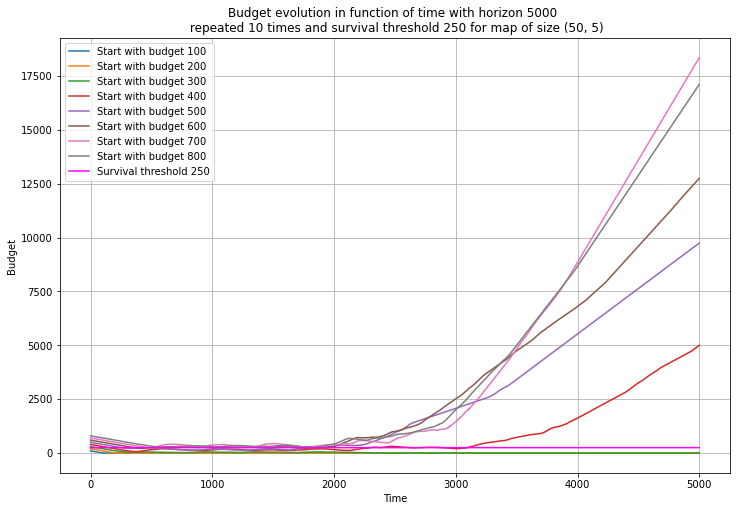

In [16]:
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(12, 8))

t = np.arange(horizon)

for i, evo in enumerate(qsurvival_budget_evolutions_mean):
    if len(show_only) > 0 and budgets[i] not in show_only:
        continue
    
    lines = plt.plot(t, evo, label=f"Start with budget {budgets[i]}")

    if with_bounds:
        plt.fill_between(t, qsurvival_budget_evolutions_min[i], qsurvival_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}")
#plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
#plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

## Success

### Classic QLearning

In [ ]:
target_states = env.get_target_states()

target_means = dict()
for label, state in target_states.items():

    values = list()

    for j, b in enumerate(budgets):
        values.append(np.sum(qclassic_exploration_map[j][state, :]))

    target_means[label] = values

x = np.arange(len(budgets))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in target_means.items():
    offset = (width) * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of passages')
ax.set_title(f"Average number of passages through a positive reward \n as a function of budget for {repeat} repeat")
ax.set_xticks(x + 0.5 * width, budgets)
ax.legend(loc='upper left', ncols=3)
plt.show()

### Survival QLearning

In [ ]:
target_states = env.get_target_states()

target_means = dict()
for label, state in target_states.items():

    values = list()

    for j, b in enumerate(budgets):
        values.append(np.sum(qsurvival_exploration_map[j][state, :]))

    target_means[label] = values

x = np.arange(len(budgets))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in target_means.items():
    offset = (width) * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of passages')
ax.set_title(f"Average number of passages through a positive reward \n as a function of budget for {repeat} repeat")
ax.set_xticks(x + 0.5 * width, budgets)
ax.legend(loc='upper left', ncols=3)
plt.show()

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

## Visit

In [ ]:
env.close()